<h1>Session 14. Fully tuned and Evaluated Decision Tree and Logistic Regression with Bank data</h1>
<p>This notebook provides an example code of predicting whether the client will subscribe a term deposit or not 
<br>
<b>Dependent variable (y)</b> - has the client subscribed a term deposit? (1-yes, 0-no)

<br><br>

The general sequence of steps that we will follow is the following:
<ol>
<li>Describing the data (checking for NAs, 0 variance,summary statistics of our variables, etc)
<li>Separate data into numeric and objec datasets, so to be able to create dummy variables
<li>Checking for correlations between numeric variables, and see that there are many correlated variables
<li>Devide data into training and testing sets 
<li><b> Model 1. Decision tree without scaling the data</b>
<li><b> Model 2. Decision tree with scaled data</b>
<li><b> Model 3. Logistic Regression from statsmodel and interpretation of marginal effects</b>
<li><b> Model 4. Logistic Regression without scaling the data</b>
<li> Predicting for new individual using constructed models
<li> Summarising results
</ol>
</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,export_graphviz 
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [2]:
data=pd.read_excel("bank.xlsx")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
age               4119 non-null int64
job               4119 non-null object
marital           4119 non-null object
education         4119 non-null object
default           4119 non-null object
housing           4119 non-null object
loan              4119 non-null object
contact           4119 non-null object
month             4119 non-null object
day_of_week       4119 non-null object
duration          4119 non-null int64
campaign          4119 non-null int64
pdays             4119 non-null int64
previous          4119 non-null int64
poutcome          4119 non-null object
emp_var_rate      4119 non-null float64
cons_price_idx    4119 non-null float64
cons_conf_idx     4119 non-null float64
euribor3m         4119 non-null float64
nr_employed       4119 non-null float64
y                 4119 non-null int64
dtypes: float64(5), int64(6), object(10)
memory usage: 675.9+ KB


In [4]:
data_numeric=data.select_dtypes(exclude="object")
data_object=data.select_dtypes(include="object")

In [5]:
data_numeric.var()==0

age               False
duration          False
campaign          False
pdays             False
previous          False
emp_var_rate      False
cons_price_idx    False
cons_conf_idx     False
euribor3m         False
nr_employed       False
y                 False
dtype: bool

In [6]:
for i in data_object.columns:
    print(data_object[i].unique())

['blue_collar' 'services' 'admin_' 'entrepreneur' 'self_employed'
 'technician' 'management' 'student' 'retired' 'housemaid' 'unemployed'
 'unknown']
['married' 'single' 'divorced' 'unknown']
['basic_9y' 'high_school' 'university_degree' 'professional_course'
 'basic_6y' 'basic_4y' 'unknown' 'illiterate']
['no' 'unknown' 'yes']
['yes' 'no' 'unknown']
['no' 'unknown' 'yes']
['cellular' 'telephone']
['may' 'jun' 'nov' 'sep' 'jul' 'aug' 'mar' 'oct' 'apr' 'dec']
['fri' 'wed' 'mon' 'thu' 'tue']
['nonexistent' 'failure' 'success']


In [7]:
data_object.nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64

In [8]:
data_dummies=pd.get_dummies(data_object,prefix=data_object.columns,drop_first=True)

In [9]:
data_final=data_dummies.join(data_numeric)
X=data_final.drop("y",axis=1)
Y=data_final.y
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [10]:
Y.value_counts()/len(Y)*100

0    89.05074
1    10.94926
Name: y, dtype: float64

# Model 1. Decision Tree with not balanced data

In [11]:
gridsearch1=GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid={"max_depth":range(10,16),"min_samples_leaf":range(50,150,10),"class_weight":["balanced", None]},scoring="roc_auc",cv=5,n_jobs=-1)
gridsearch1.fit(X,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(10, 16), 'min_samples_leaf': range(50, 150, 10), 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [12]:
print(gridsearch1.best_params_)

{'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 50}


In [13]:
tree1=DecisionTreeClassifier(class_weight=None,max_depth=10,min_samples_leaf=70,random_state=42)
tree1.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=70, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [14]:
y_pred1=tree1.predict(x_test)
print("roc_auc:",roc_auc_score(y_test,y_pred1))
print("train_score:",tree1.score(x_train,y_train))
print("test_score:",tree1.score(x_test,y_test))
print("recall:",recall_score(y_test,y_pred1))

roc_auc: 0.7375808106465848
train_score: 0.9190676594367109
test_score: 0.9067961165048544
recall: 0.5229357798165137


In [15]:
#printing predicted probabilities for 0 and 1 classes, the probabilities for 1 class will be used to construct ROC curve
print(pd.DataFrame(tree1.predict_proba(x_test)[:6,:]))

          0         1
0  0.228261  0.771739
1  1.000000  0.000000
2  1.000000  0.000000
3  0.426966  0.573034
4  0.903226  0.096774
5  1.000000  0.000000


In [16]:
#ROC curve
FPR,TPR,tresholds=roc_curve(y_test,tree1.predict_proba(x_test)[:,1])
print(FPR,TPR)

[0.         0.01628664 0.0369164  0.04777416 0.0781759  0.09337676
 0.12269273 0.1465798  0.18241042 0.22258415 0.247557   0.29315961
 0.330076   0.36047774 0.38870793 0.41042345 0.44082519 1.        ] [0.         0.19266055 0.40366972 0.52293578 0.6146789  0.73394495
 0.78899083 0.80733945 0.85321101 0.93577982 0.96330275 0.98165138
 0.98165138 0.98165138 0.99082569 0.99082569 0.99082569 1.        ]


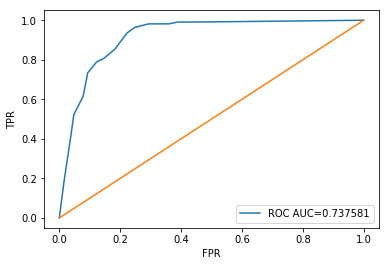

In [17]:
plt.plot(FPR,TPR,label="ROC AUC=%f"%roc_auc_score(y_test,y_pred1))
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

# Model 2. Decision Tree with scaled data

In [18]:
#let's scale data
scaler=StandardScaler()
data_numeric_new=data_numeric.drop("y",axis=1)
scaler.fit(data_numeric_new)
data_numeric_scaled=pd.DataFrame(scaler.transform(data_numeric_new),columns=data_numeric_new.columns)

In [19]:
data_numeric_scaled.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,-0.980752,0.903952,-0.209228,0.201031,-0.351356,-1.206054,-1.185448,-1.240939,-1.331707,-0.914779
1,-0.107991,0.350300,0.569634,0.201031,-0.351356,0.649441,0.715193,0.892269,0.711698,0.332862
2,-1.465619,-0.116966,-0.598660,0.201031,-0.351356,0.841389,1.528273,-0.283172,0.773427,0.836535
3,-0.204965,-0.941553,0.180203,0.201031,-0.351356,0.841389,1.528273,-0.283172,0.771697,0.836535
4,0.667795,-0.780563,-0.598660,0.201031,-0.351356,-0.118350,-0.655478,-0.326707,0.328632,0.398028


In [20]:
X_scaled=data_numeric_scaled.join(data_dummies)
x_train_scaled,x_test_scaled,y_train,y_test=train_test_split(X_scaled,Y,test_size=0.25,random_state=42)

In [21]:
X_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 53 columns):
age                              4119 non-null float64
duration                         4119 non-null float64
campaign                         4119 non-null float64
pdays                            4119 non-null float64
previous                         4119 non-null float64
emp_var_rate                     4119 non-null float64
cons_price_idx                   4119 non-null float64
cons_conf_idx                    4119 non-null float64
euribor3m                        4119 non-null float64
nr_employed                      4119 non-null float64
job_blue_collar                  4119 non-null uint8
job_entrepreneur                 4119 non-null uint8
job_housemaid                    4119 non-null uint8
job_management                   4119 non-null uint8
job_retired                      4119 non-null uint8
job_self_employed                4119 non-null uint8
job_services             

In [22]:
gridsearch2=GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid={"max_depth":range(10,16),"min_samples_leaf":range(50,150,10),"class_weight":["balanced", None]},cv=5,n_jobs=-1)
gridsearch2.fit(X_scaled,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(10, 16), 'min_samples_leaf': range(50, 150, 10), 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
print(gridsearch1.best_params_)

{'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 50}


In [24]:
tree2=DecisionTreeClassifier(class_weight=None,max_depth=10,min_samples_leaf=70,random_state=42)
tree2.fit(x_train_scaled,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=70, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [25]:
y_pred2=tree2.predict(x_test_scaled)
print("roc_auc:",roc_auc_score(y_test,y_pred2))
print("train_score:",tree2.score(x_train_scaled,y_train))
print("test_score:",tree2.score(x_test_scaled,y_test))
print("recall:",recall_score(y_test,y_pred2))

roc_auc: 0.7375808106465848
train_score: 0.9190676594367109
test_score: 0.9067961165048544
recall: 0.5229357798165137


<b>No difference beween models with scaled and not scaled data.</b>

# Model 3. Logit from statsmodel, interpreting results

In [26]:
formula="y~"+"+".join(X.columns)
formula

'y~job_blue_collar+job_entrepreneur+job_housemaid+job_management+job_retired+job_self_employed+job_services+job_student+job_technician+job_unemployed+job_unknown+marital_married+marital_single+marital_unknown+education_basic_6y+education_basic_9y+education_high_school+education_illiterate+education_professional_course+education_university_degree+education_unknown+default_unknown+default_yes+housing_unknown+housing_yes+loan_unknown+loan_yes+contact_telephone+month_aug+month_dec+month_jul+month_jun+month_mar+month_may+month_nov+month_oct+month_sep+day_of_week_mon+day_of_week_thu+day_of_week_tue+day_of_week_wed+poutcome_nonexistent+poutcome_success+age+duration+campaign+pdays+previous+emp_var_rate+cons_price_idx+cons_conf_idx+euribor3m+nr_employed'

In [27]:
logit1=Logit.from_formula(formula=formula,data=data_final).fit()

Optimization terminated successfully.
         Current function value: 0.193937
         Iterations 17


In [28]:
logit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4119
Model:                          Logit   Df Residuals:                     4066
Method:                           MLE   Df Model:                           52
Date:                Wed, 21 Nov 2018   Pseudo R-squ.:                  0.4386
Time:                        21:38:08   Log-Likelihood:                -798.83
converged:                       True   LL-Null:                       -1422.9
                                        LLR p-value:                4.652e-227
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                      -144.7479    122.785     -1.179      0.238    -385.402      95.906
job_blue_collar                  -0.2269      0.271     -0.839      0.402      -0.757       0.303
job_entrepreneur                 -0.7740      0.499     -1.552      0.121      -1.752       0.204
job_housemaid                     0.2477      0.446      0.555      0.579      -0.627       1.122
job_management                   -0.3136      0.285     -1.099      0.272      -0.873       0.246
job_retired                      -0.2069      0.346     -0.597      0.550      -0.886       0.472
job_self_employed                -0.7305      0.416     -1.755      0.079      -1.547       0.086
job_services                      0.1251      0.282      0.443      0.657      -0.428       0.678
job_student                      -0.0737      0.398     -0.185      0.853      -0.854       0.707
job_technician                    0.2209      0.224      0.985      0.325      -0.219       0.661
job_unemployed                    0.3362      0.391      0.859      0.390      -0.430       1.103
job_unknown                      -0.4624      0.725     -0.637      0.524      -1.884       0.959
marital_married                   0.2782      0.246      1.132      0.257      -0.203       0.760
marital_single                    0.3277      0.280      1.171      0.241      -0.221       0.876
marital_unknown                   0.2769      1.145      0.242      0.809      -1.966       2.520
education_basic_6y                0.3219      0.408      0.789      0.430      -0.477       1.121
education_basic_9y                0.2012      0.321      0.626      0.531      -0.429       0.831
education_high_school             0.1515      0.307      0.494      0.621      -0.449       0.752
education_illiterate           -133.4699   2.78e+29  -4.81e-28      1.000   -5.44e+29    5.44e+29
education_professional_course     0.1169      0.336      0.348      0.728      -0.541       0.774
education_university_degree       0.3189      0.309      1.033      0.302      -0.286       0.924
education_unknown                 0.2426      0.388      0.626      0.532      -0.518       1.003
default_unknown                   0.1453      0.210      0.692      0.489      -0.266       0.557
default_yes                    -130.3678   2.19e+29  -5.96e-28      1.000   -4.29e+29    4.29e+29
housing_unknown                  -0.2798   4.87e+07  -5.75e-09      1.000   -9.54e+07    9.54e+07
housing_yes                      -0.0673      0.138     -0.489      0.625      -0.337       0.202
loan_unknown                     -0.2798   4.87e+07  -5.75e-09      1.000   -9.54e+07    9.54e+07
loan_yes                         -0.1144      0.187     -0.612      0.541      -0.481       0.252
contact_telephone                -0.9556      0.278     -3.432      0.001      -1.501      -0.410
month_aug                         0.4943      0.414      1.194      0.232      -0.317       1.306
month_d

In [29]:
#we should get marginal effects to be able to interpret results of logit
logit1.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
job_blue_collar                  -0.0126      0.015     -0.840      0.401      -0.042       0.017
job_entrepreneur                 -0.0429      0.028     -1.544      0.123      -0.097       0.012
job_housemaid                     0.0137      0.025      0.555      0.579      -0.035       0.062
job_management                   -0.0174      0.016     -1.101      0.271      -0.048       0.014
job_retired                      -0.0115      0.019     -0.598      0.550      -0.049       0.026
job_self_employed                -0.0405      0.023     -1.757      0.079      -0.086       0.005
job_services                      0.0069      0.016      0.443      0.657      -0.024       0.038
job_student                      -0.0041      0.022     -0.185      0.853      -0.047       0.039
job_technician                    0.0123      0.012      0.984      0.325      -0.012       0.037
job_unemployed                    0.0187      0.022      0.860      0.390      -0.024       0.061
job_unknown                      -0.0257      0.040     -0.638      0.524      -0.105       0.053
marital_married                   0.0154      0.014      1.133      0.257      -0.011       0.042
marital_single                    0.0182      0.016      1.172      0.241      -0.012       0.049
marital_unknown                   0.0154      0.063      0.242      0.809      -0.109       0.140
education_basic_6y                0.0179      0.023      0.790      0.430      -0.026       0.062
education_basic_9y                0.0112      0.018      0.626      0.531      -0.024       0.046
education_high_school             0.0084      0.017      0.494      0.621      -0.025       0.042
education_illiterate             -7.4045   1.53e+28  -4.84e-28      1.000      -3e+28       3e+28
education_professional_course     0.0065      0.019      0.348      0.728      -0.030       0.043
education_university_degree       0.0177      0.017      1.033      0.302      -0.016       0.051
education_unknown                 0.0135      0.022      0.626      0.532      -0.029       0.056
default_unknown                   0.0081      0.012      0.692      0.489      -0.015       0.031
default_yes                      -7.2324   9.52e+27   -7.6e-28      1.000   -1.87e+28    1.87e+28
housing_unknown                  -0.0155    2.7e+06  -5.75e-09      1.000   -5.29e+06    5.29e+06
housing_yes                      -0.0037      0.008     -0.489      0.625      -0.019       0.011
loan_unknown                     -0.0155    2.7e+06  -5.75e-09      1.000   -5.29e+06    5.29e+06
loan_yes                         -0.0063      0.010     -0.612      0.541      -0.027       0.014
contact_telephone                -0.0530      0.015     -3.451      0.001      -0.083      -0.023
month_aug                         0.0274      0.023      1.194      0.233      -0.018       0.072
month_dec                         0.0492      0.037      1.314      0.189      -0.024       0.123
month_jul                         0.0052      0.020      0.260      0.795      -0.034       0.045
month_jun                         0.0306      0.024      1.271      0.204      -0.017       0.078
month_mar                         0.1373      0.029      4.815      0.000       0.081       0.193
month_may                        -0.0179      0.017     -1.074      0.283      -0.051       0.015
month_nov                        -0.0180      0.023     -0.774      0.439      -0.063       0.028
month_oct                         0.01

<b>As we can see from the summary and from marginal effects, p-value for cons_conf_idx is less than 0.05, so we can conclude that there is a significant relationship between dependent variable and cons_conf_idx. Incremental increase in cons_conf_idx will increase the probability of subscribing deposit on average by 0.36% (0.0036*100%) when other factors are held constant.</b>

# Model 4. Logit from sklearn with not scaled data

In [30]:
gridsearch3=GridSearchCV(LogisticRegression(random_state=42),
                         param_grid={"C":np.linspace(0.0001,50,10),"class_weight":[None,"balanced"]},
                         scoring="roc_auc",cv=5,n_jobs=-1)
gridsearch3.fit(X,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([1.00000e-04, 5.55564e+00, 1.11112e+01, 1.66667e+01, 2.22223e+01,
       2.77778e+01, 3.33334e+01, 3.88889e+01, 4.44445e+01, 5.00000e+01]), 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [31]:
print(gridsearch3.best_params_)
best=list(gridsearch3.best_params_.values())[0]

{'C': 11.111188888888888, 'class_weight': 'balanced'}


In [32]:
logit2=LogisticRegression(C=best,random_state=42,class_weight="balanced")
logit2.fit(x_train,y_train)

LogisticRegression(C=11.111188888888888, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [33]:
y_pred3=logit2.predict(x_test)
print("roc_auc:",roc_auc_score(y_test,y_pred3))
print("train_score:",logit2.score(x_train,y_train))
print("test_score:",logit2.score(x_test,y_test))
print("recall:",recall_score(y_test,y_pred3))

roc_auc: 0.8492713345087609
train_score: 0.8711557138232437
test_score: 0.8533980582524272
recall: 0.8440366972477065


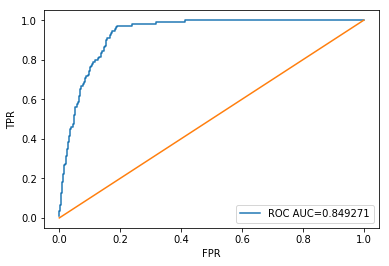

In [34]:
#ROC curve
FPR,TPR,tresholds=roc_curve(y_test,logit2.predict_proba(x_test)[:,1])
plt.plot(FPR,TPR,label="ROC AUC=%f"%roc_auc_score(y_test,y_pred3))
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

<h1>Predicting for new individual using constructed models</h1>

In [35]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 54 columns):
job_blue_collar                  4119 non-null uint8
job_entrepreneur                 4119 non-null uint8
job_housemaid                    4119 non-null uint8
job_management                   4119 non-null uint8
job_retired                      4119 non-null uint8
job_self_employed                4119 non-null uint8
job_services                     4119 non-null uint8
job_student                      4119 non-null uint8
job_technician                   4119 non-null uint8
job_unemployed                   4119 non-null uint8
job_unknown                      4119 non-null uint8
marital_married                  4119 non-null uint8
marital_single                   4119 non-null uint8
marital_unknown                  4119 non-null uint8
education_basic_6y               4119 non-null uint8
education_basic_9y               4119 non-null uint8
education_high_school            4119 non-nul

In [36]:
#let's give random values to each variable which will describe our new customer
X_new=[[0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,25,25,30,9,2,1.4,92,-36,4.2,5000]]

In [37]:
##Predicting for unseen X_new using logit and DT
log_p=logit2.predict(X_new)
DT_p=tree1.predict(X_new)
print("logit_pred:",log_p)
print("tree_pred",DT_p)

logit_pred: [0]
tree_pred [0]


<b>Both models predicted 0 class for our new customer. So, new customer won't subscribe deposit in our bank according to two models.</b>

In [38]:
#Printing recall for not scaled data models
print("Recall scores for not scaled models")
for i in [tree1,logit2]:
    print("Recall:",(recall_score(y_test,i.predict(x_test))).round(2)*100)
print("\n","---------------------------------------")

#ROC AUC
print("ROC AUC scores for not scaled models")
for i in [tree1,logit2]:
    print("ROC AUC:",(roc_auc_score(y_test,i.predict(x_test))).round(2)*100)
    
print("\n","---------------------------------------")
print("Train scores for not scaled models")
for i in [tree1,logit2]:
    print("Train scores:",(i.score(x_train,y_train)).round(2)*100)

print("\n","---------------------------------------")
print("Test scores for not scaled models")
for i in [tree1,logit2]:
    print("Test scores:",(i.score(x_test,y_test)).round(2)*100)

Recall scores for not scaled models
Recall: 52.0
Recall: 84.0

 ---------------------------------------
ROC AUC scores for not scaled models
ROC AUC: 74.0
ROC AUC: 85.0

 ---------------------------------------
Train scores for not scaled models
Train scores: 92.0
Train scores: 87.0

 ---------------------------------------
Test scores for not scaled models
Test scores: 91.0
Test scores: 85.0


<b>Accuracy</b> is higher for Decision tree but <b>ROC AUC</b> and <b>Recall scores</b> are less compared to logistic regression. 